In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from IPython.display import clear_output
import numpy as np
import os
import pandas as pd
import shutil

import sys
sys.path.append('..')

from lib.ChurnEnsemble import ChurnEnsemble
from lib.utils import print_censored_rate, transform_data

SEED = 42
np.random.seed(SEED)

2024-07-02 02:24:14.271235: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
params = dict(
    wtte=dict(
        features=[
            'plan', 'interval', 'country_es', 'country_mx', 'country_latam', 'gateway_auto',
            'failed', 'usage', 'usage_groups', 'usage_payments', 'momentum'
        ],
        params={}
    ),
    xgb=dict(
        features=[
            'employees', 'interval', 'country_es', 'country_mx', 'country_latam', 'gateway_auto',
            'plan', 'usage', 'usage_groups', 'usage_payments', 'usage_avg',
            'paid_periods', 'months', 'failed_ratio', 'momentum'
        ],
        params={}
    )
)

min_tte = 1  # Minimum time to event for binary classification (positive if `tte` <= `min_tte`)
max_sl = 24  # Maximum sequence length (0 = max length from data)
test_size = 0.25  # Percentage of the data to use for test/validation

In [3]:
data = pd.read_csv('../files/data/churn-data-fit.csv')

data = transform_data(data)

clear_output(wait=True)
print_censored_rate(data)
data

Total Customers: 11.637 | Censored: 2.381 | Non-censored: 9.256 | Censored Rate 20,46%


,cid,id,tp,tfs,tte,ts,te,employees,mrr,value,...,usage_avg,usage_groups_avg,usage_payments_avg,paid_periods,failed_periods,active_periods,months,failed_ratio,usage_diff,momentum
0,5142ef7b2169540c17000001,1,2015-03-01,0.0,1.0,2015-03-01,2015-04-01,3,10.90,10.90,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5142ef7b2169540c17000001,1,2015-04-01,1.0,0.0,2015-03-01,2015-04-01,3,10.90,10.90,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-2.2
2,51643b584bcdb1cc6800001e,2,2015-01-01,0.0,26.0,2015-01-01,2017-03-01,1,9.26,9.26,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,51643b584bcdb1cc6800001e,2,2015-02-01,1.0,25.0,2015-01-01,2017-03-01,1,9.26,18.52,...,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0
4,51643b584bcdb1cc6800001e,2,2015-03-01,2.0,24.0,2015-01-01,2017-03-01,1,8.26,117.69,...,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215641,66103d1c508579d0d5fc9727,11633,2024-03-01,0.0,1.0,2024-03-01,2024-04-01,1,52.79,52.79,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
215642,66105263508579d0d5fca27d,11634,2024-03-01,0.0,-1.0,2024-03-01,NaT,1,72.75,72.75,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
215643,661063c1508579d0d5fcae2c,11635,2024-03-01,0.0,-1.0,2024-03-01,NaT,1,41.97,41.97,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
215644,66106e13423bb304f227d752,11636,2024-03-01,0.0,-1.0,2024-03-01,NaT,1,32.15,32.15,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Clean previous data path
if os.path.exists('../files/ensemble'):
    shutil.rmtree('../files/ensemble')

# Instantiate Ensemble model, set parameters and data
model = ChurnEnsemble(
    min_tte=min_tte,
    max_sl=max_sl,
    seed=SEED,
    verbose=2,
    path='../files/ensemble',
    **params
).set_data(
    data,
    test_size=test_size
).build_model()

print_censored_rate(model.dtrain, 'Train')
print_censored_rate(model.dtest, 'Test')
model.get_params()

Train Customers: 8.727 | Censored: 1.786 | Non-censored: 6.941 | Censored Rate 20,47%
Test Customers: 2.910 | Censored: 595 | Non-censored: 2.315 | Censored Rate 20,45%


{'wtte': {'nn': 0,
  'hl': 2,
  'lr': 0.0001,
  'epochs': 200,
  'batch': 512,
  'lr_decay': 0,
  'stop': 0,
  'dropout': 0.1,
  'weight_l1': 0,
  'weight_l2': 1e-05,
  'init_alpha': None,
  'max_beta': 2.0,
  'shuffle': False,
  'epsilon': 1e-08},
 'xgb': {'n': 200,
  'lr': 0.01,
  'max_depth': 16,
  'stop': 0,
  'metric': 'auc',
  'min_child_weight': 1,
  'gamma': 0,
  'weight_l1': 0,
  'weight_l2': 1,
  'dropout': 0.2,
  'shuffle': False,
  'reg_unb': True}}

In [5]:
# Fit WTTE model
model.fit_wtte()

discrete -> Max Length: 24 | Mask: -6.50
Alpha Mean: 8.80 | Beta Mean: 0.67
Init Alpha: 9.30 | Max Beta: 2.00


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, None, 11)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 24)       │         3,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, None, 24)       │            48 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, None, 24)       │         4,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, None, 24)       │            48 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 2)        │            50 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, None, 2)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,306 (32.45 KB)

 Trainable params: 8,306 (32.45 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
18/18 - 7s - 375ms/step - loss: 2.9339 - val_loss: 2.7793
Epoch 2/200
18/18 - 1s - 73ms/step - loss: 2.7567 - val_loss: 2.5801
Epoch 3/200
18/18 - 1s - 73ms/step - loss: 2.6293 - val_loss: 2.4700
Epoch 4/200
18/18 - 1s - 72ms/step - loss: 2.5349 - val_loss: 2.3909
Epoch 5/200
18/18 - 1s - 75ms/step - loss: 2.4717 - val_loss: 2.3431
Epoch 6/200
18/18 - 1s - 73ms/step - loss: 2.4257 - val_loss: 2.3160
Epoch 7/200
18/18 - 1s - 74ms/step - loss: 2.3930 - val_loss: 2.2981
Epoch 8/200
18/18 - 1s - 74ms/step - loss: 2.3631 - val_loss: 2.2842
Epoch 9/200
18/18 - 1s - 79ms/step - loss: 2.3453 - val_loss: 2.2728
Epoch 10/200
18/18 - 1s - 74ms/step - loss: 2.3279 - val_loss: 2.2637
Epoch 11/200
18/18 - 1s - 79ms/step - loss: 2.3124 - val_loss: 2.2557
Epoch 12/200
18/18 - 2s - 85ms/step - loss: 2.3005 - val_loss: 2.2486
Epoch 13/200
18/18 - 2s - 84ms/step - loss: 2.2894 - val_loss: 2.2422
Epoch 14/200
18/18 - 2s - 84ms/step - loss: 2.2862 - val_loss: 2.2365
Epoch 15/200
18/18 - 1s - 77

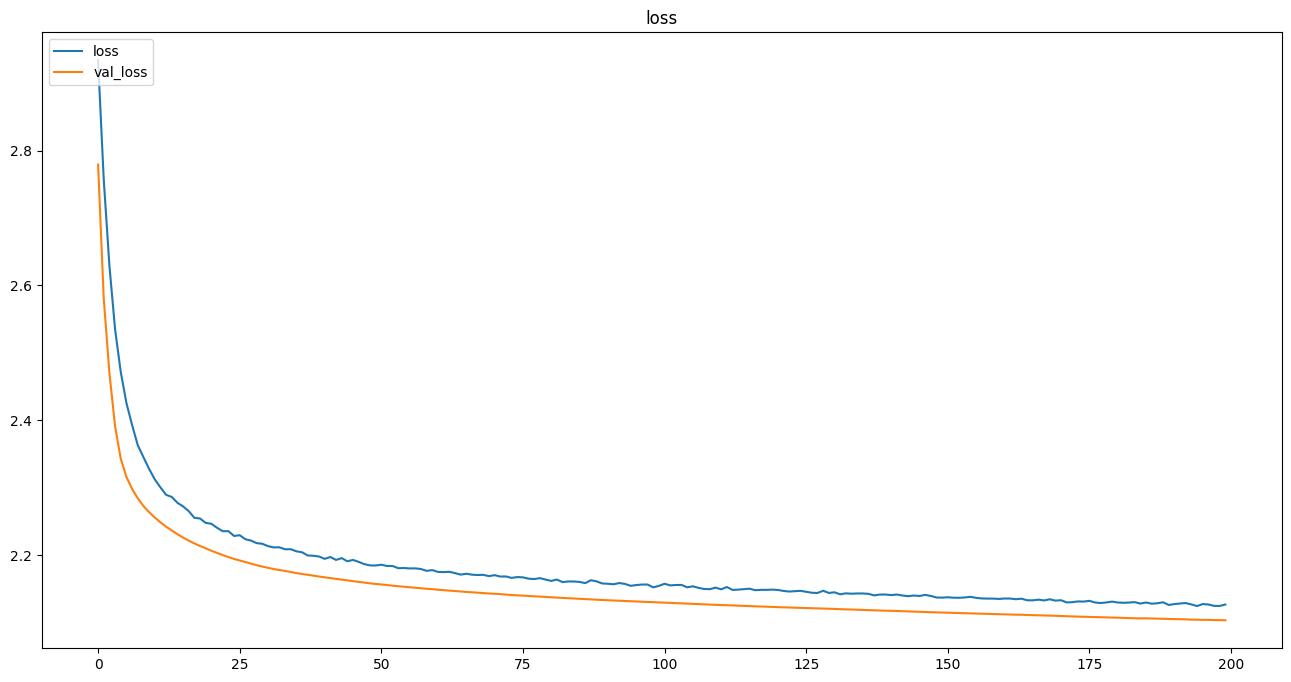

In [6]:
# Plot training history
model.wtte.plot_history_eval()

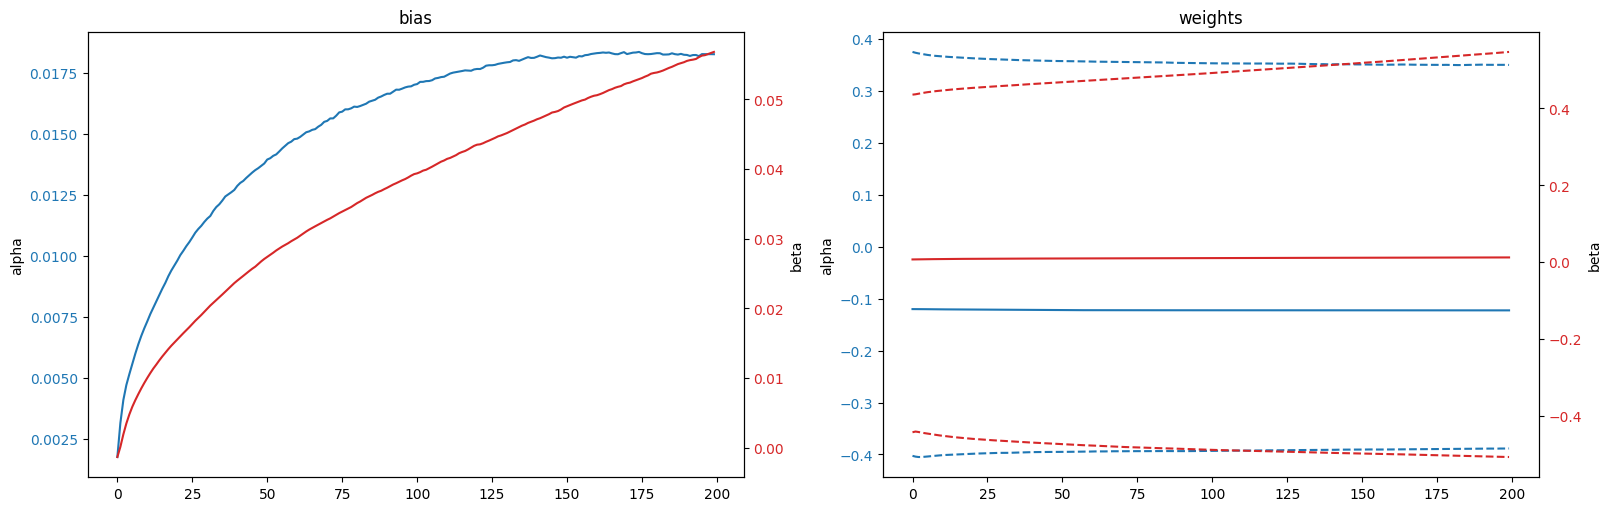

In [7]:
# Plot training weights
model.wtte.plot_weights()

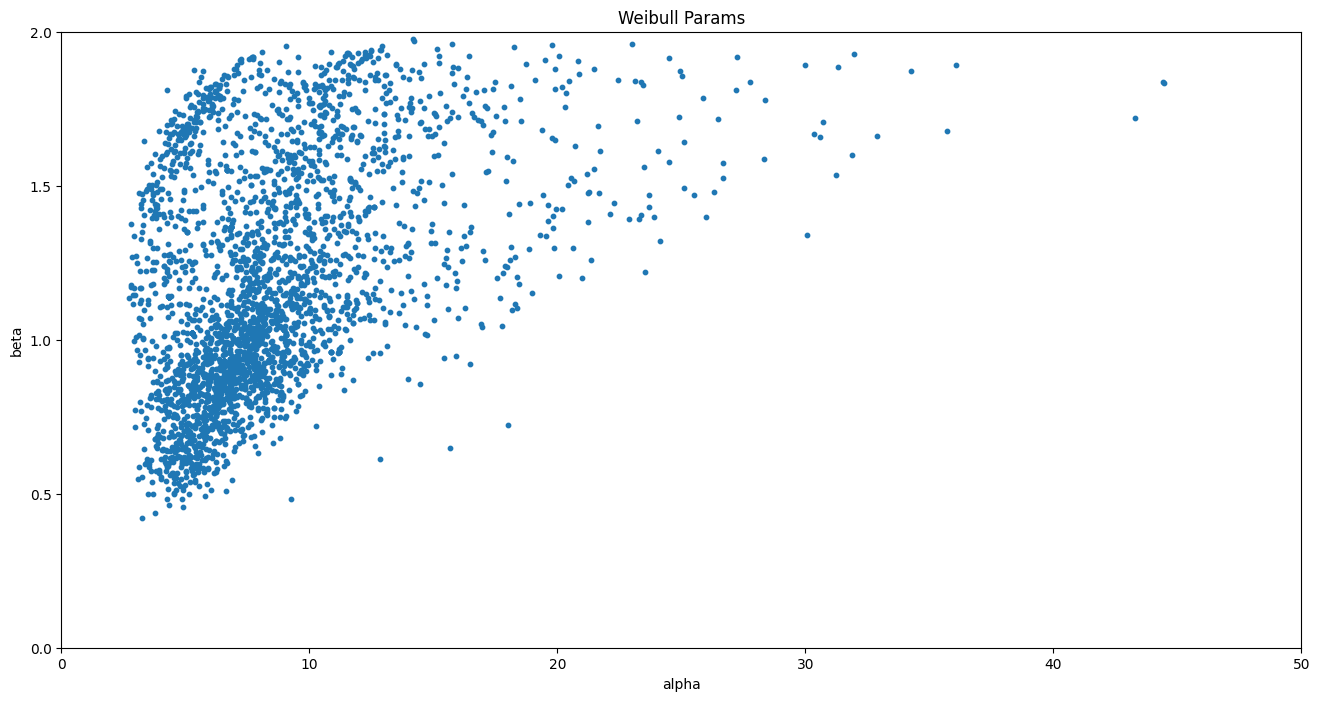

In [8]:
# Plot parameters distribution
model.wtte.plot_params_dist(model.wtte.results, loc=-1)

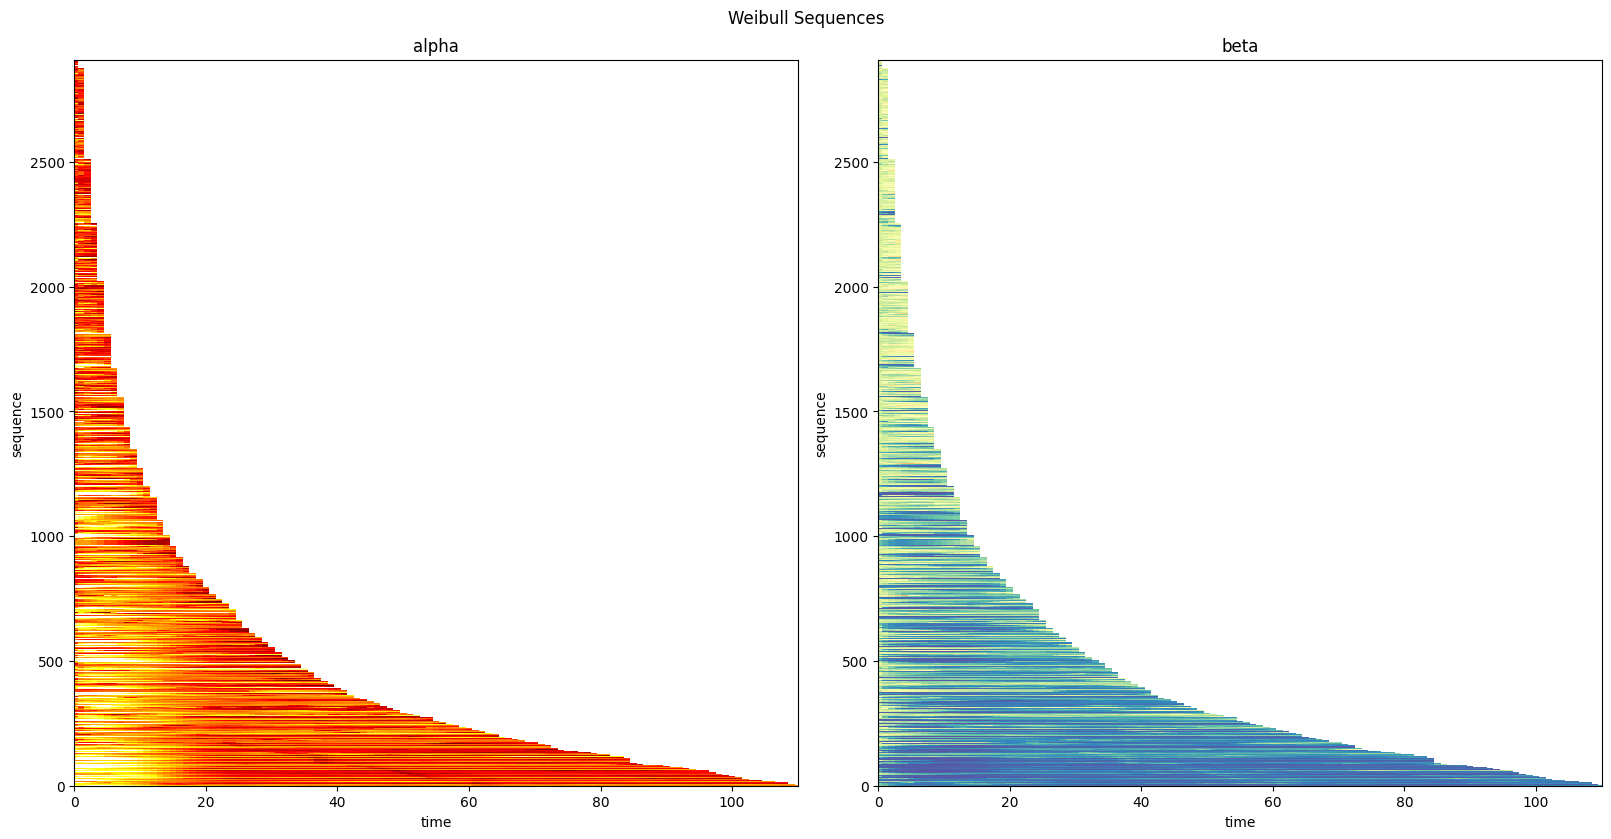

In [9]:
# Plot each customer Weibull alpha and beta parameters over time
model.wtte.plot_params_seq(model.wtte.results)

In [10]:
# Fit XGBoost model
model.fit_xgb()

2831/2831 ━━━━━━━━━━━━━━━━━━━━ 33s 12ms/step
[02:33:02] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 5782 extra nodes, 0 pruned nodes, max_depth=16
[0]	validation_0-auc:0.92828	validation_1-auc:0.82357
[02:33:02] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 5880 extra nodes, 0 pruned nodes, max_depth=16
[1]	validation_0-auc:0.95003	validation_1-auc:0.84333
[02:33:03] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 5408 extra nodes, 0 pruned nodes, max_depth=16
[2]	validation_0-auc:0.95560	validation_1-auc:0.85121
[02:33:03] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning e

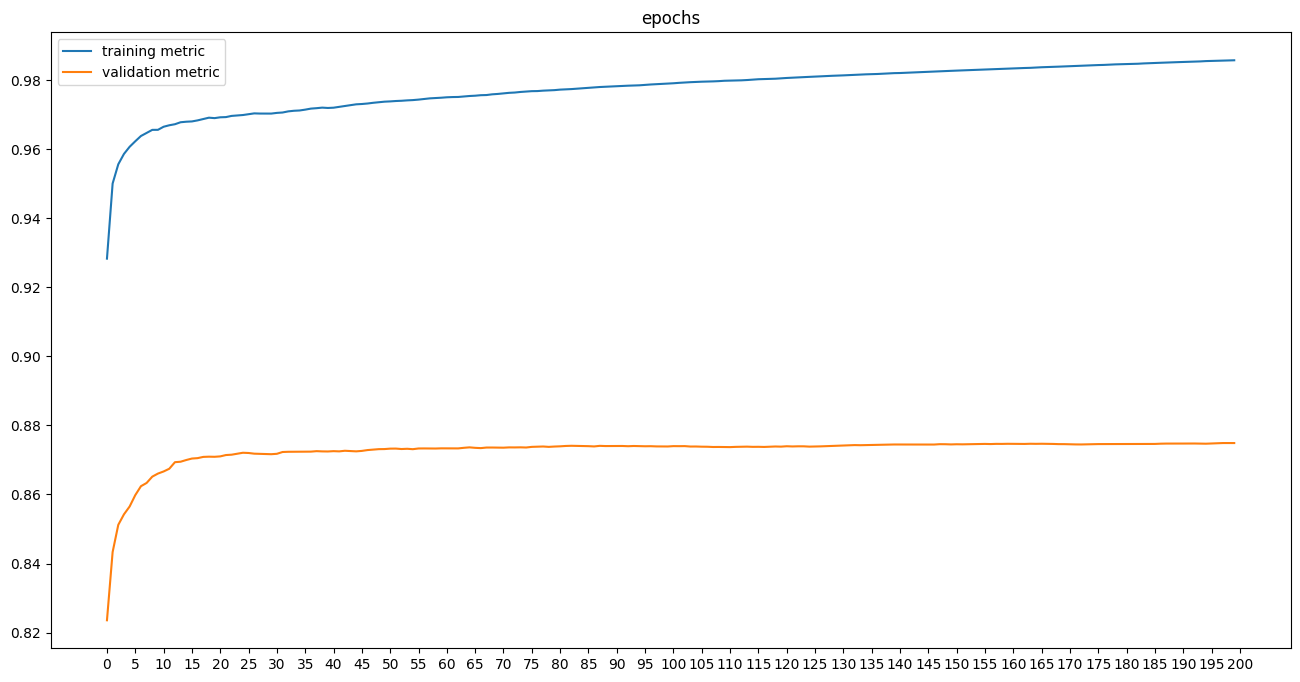

In [11]:
# Plot training history
model.xgb.plot_history_eval()

In [12]:
# Set model results from XGBoost predictions
model.set_results()
# Compute and set model scores
model.set_scores()

model.results

,id,tfs,pred,true,tgt,segment,wa,wb,momentum,cid
0,2,0,0.522501,0.0,1,4,11.322782,1.034522,0.0,51643b584bcdb1cc6800001e
1,2,1,0.567196,0.0,1,4,11.740407,1.129856,0.0,51643b584bcdb1cc6800001e
2,2,2,0.144013,0.0,0,1,12.532012,1.448930,0.0,51643b584bcdb1cc6800001e
3,2,3,0.113061,0.0,0,1,12.240866,1.574071,0.0,51643b584bcdb1cc6800001e
4,2,4,0.122814,0.0,0,1,11.456832,1.615357,0.0,51643b584bcdb1cc6800001e
...,...,...,...,...,...,...,...,...,...,...
53694,11624,0,0.711630,0.0,1,5,6.791236,0.937563,0.0,660ecafcb6080c67b1acee3f
53695,11627,0,0.711630,0.0,1,5,6.791236,0.937563,0.0,660eff0c508579d0d5f9a75b
53696,11630,0,0.647976,0.0,1,4,7.943314,1.025969,0.0,660f307c508579d0d5f9bd32
53697,11634,0,0.607904,0.0,1,4,7.953609,1.021331,0.0,66105263508579d0d5fca27d


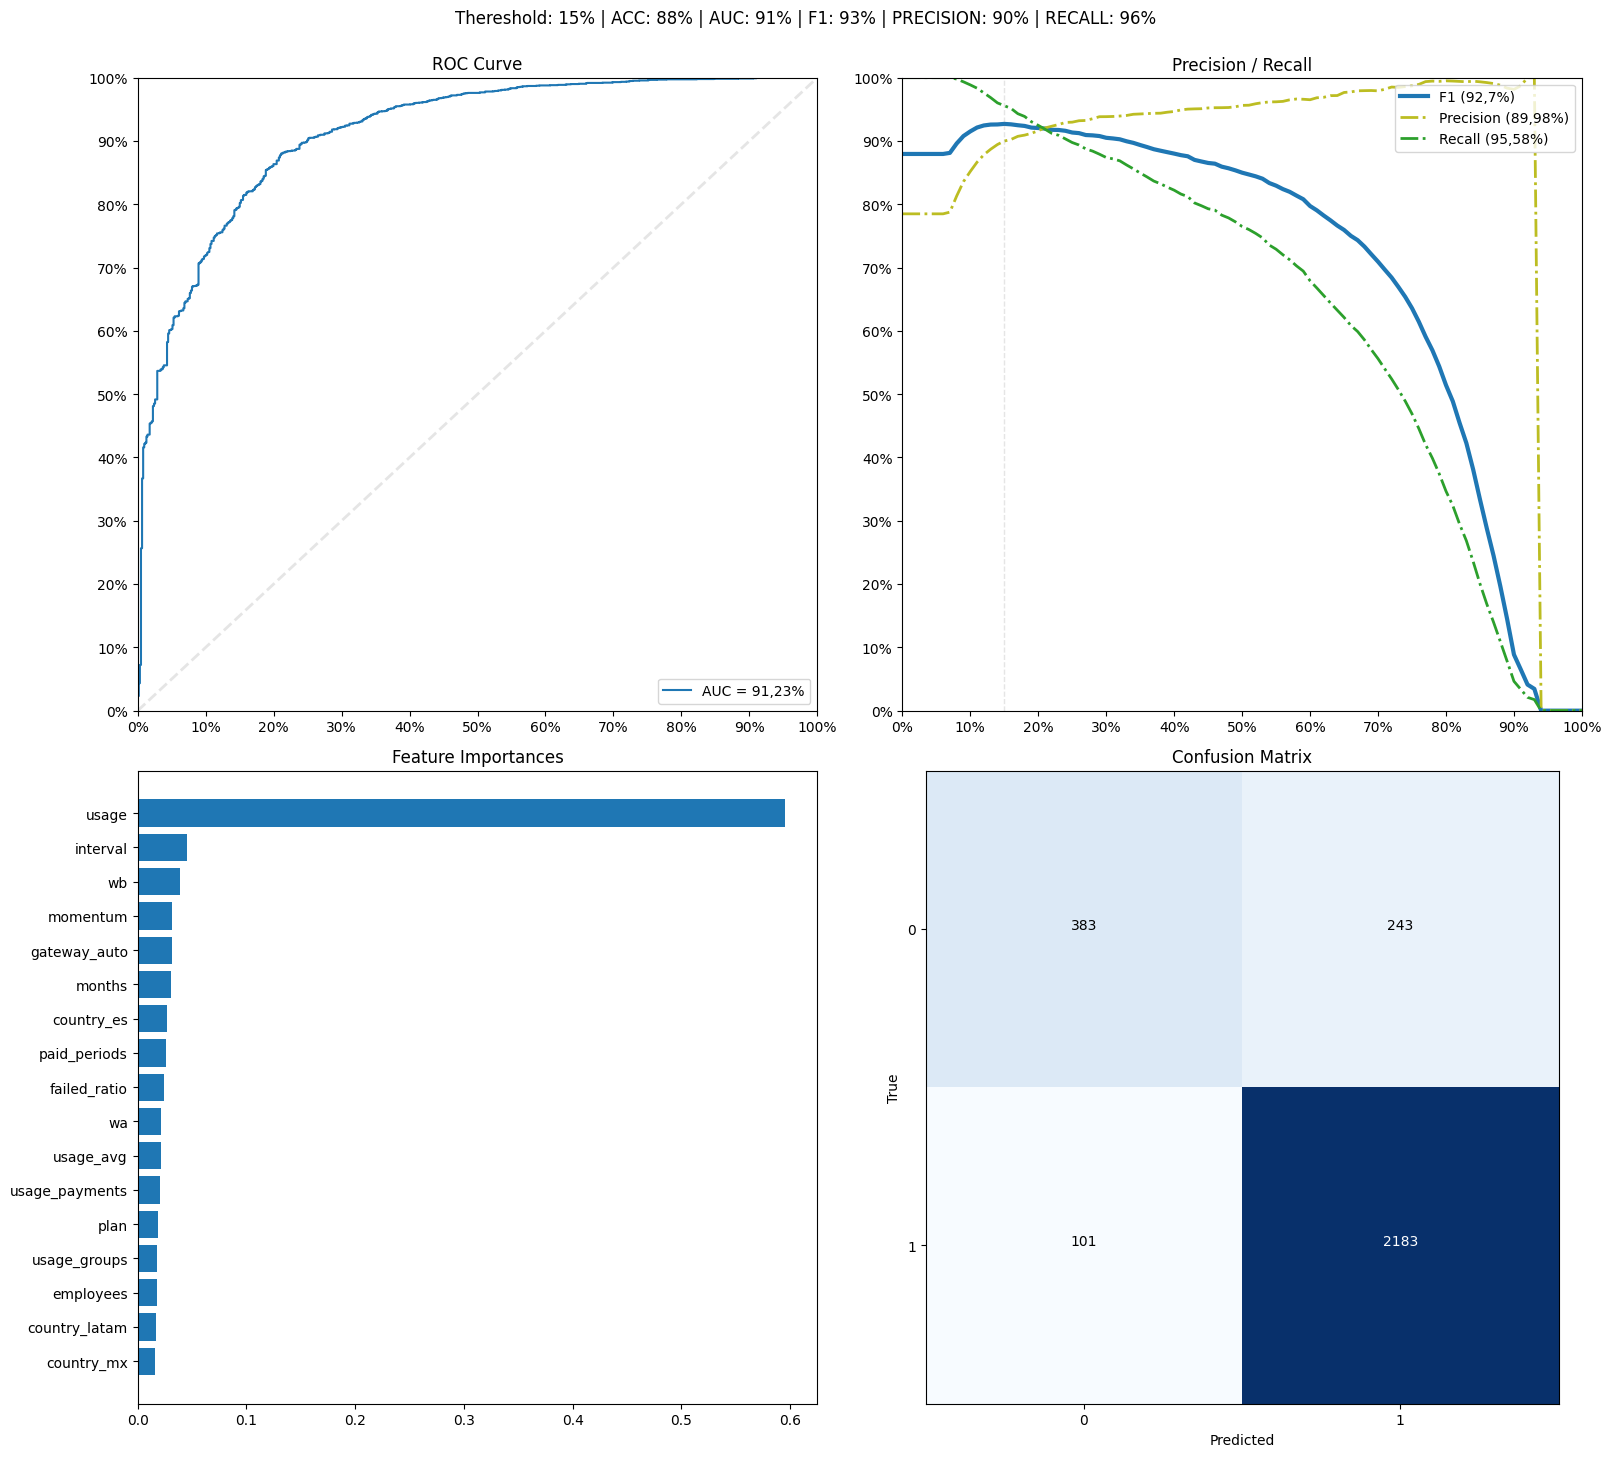

In [13]:
model.save()

# Plot scores summary
model.plot_scores()

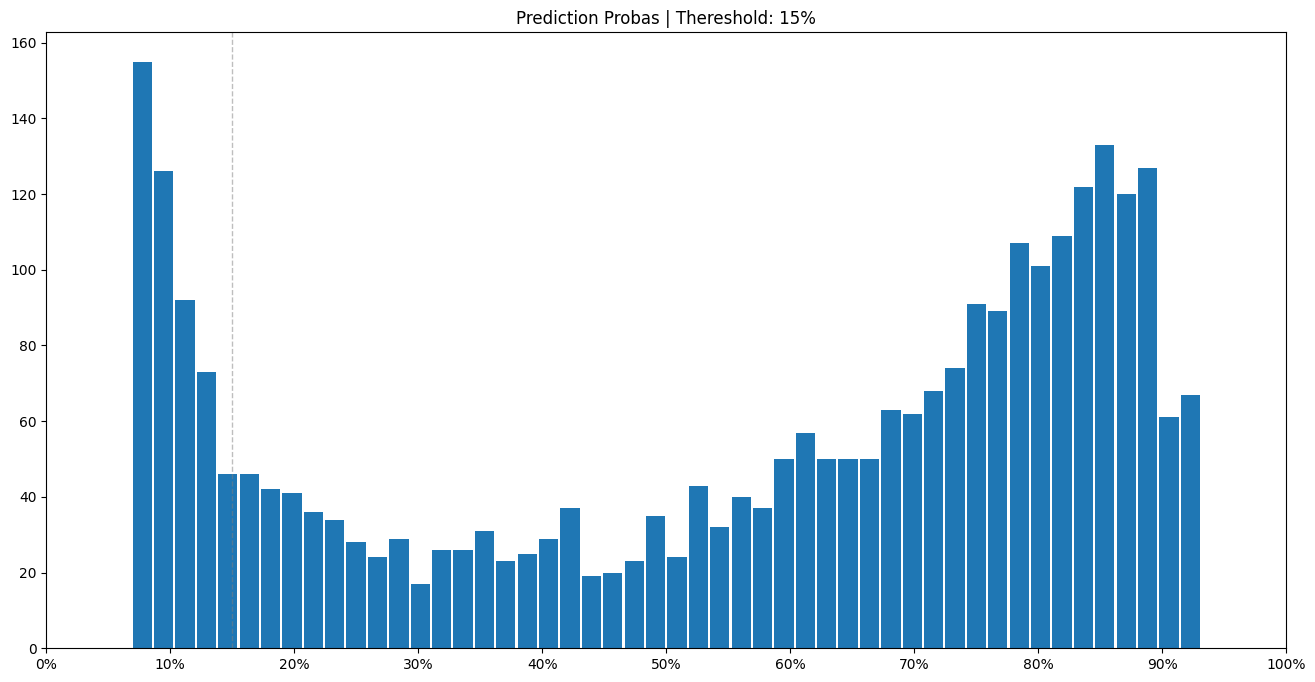

In [14]:
# Plot histogram of predicted probabilities for each customer sequence
model.plot_histogram()